In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
#Building the datatset
block_size = 3 # context_length how many words you want to use to predict the next one

def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #Leave the first ch and append the Y in context
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y


In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


4137


In [8]:
batch_size = 32
n = batch_size
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) # generates a batch_size with 32 rows
print(ix)
Xb,Yb = Xtr[ix], Ytr[ix]
print(Xb)

tensor([120000, 157809,  82137,  69514,  73004,  68734,    286, 123947,  13538,
         42674, 165010,  81021,  59151,  46471,  62456,  64636,  24418, 108817,
        169833, 145683, 168275, 157689,  36258, 142280,  32537, 149713, 149734,
        149517, 165139, 153533,  89661,  20039])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14],
        [ 0, 17,  1],
        [ 0,  0, 13],
        [13, 13,  1],
        [ 8, 25, 12],
        [ 0,  0, 26],
        [22, 15, 14],
        [19, 13,  9],
        [ 0,  0,  0],
        [ 0,  4,  5],
        [ 5, 14,  9],
        [18,  5,  5],
        [ 0,  4,  1],
        [ 1, 18,  1],
        [ 0,  0,  0],
        [ 0,  5, 12],
        [ 0, 10,  1],
        [ 9, 14,  1],
        [ 0,  0,  0],
        [ 0,  0, 18],
        [20,  5,  1],
        [ 0, 11, 15],
        [ 0,  0,  7],
        [ 0, 18,  5],
        [26,  5, 18],
        [ 0,  0, 14],
        [ 3,  5, 14],
        [ 0, 18, 15]])


In [9]:
# Forward pass
emb = C[Xb] # 32,3,10
embcat = emb.view(emb.shape[0],-1) # 32,10
#Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
#Batch Norm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True) # calculates the mean values across the batch dimension and normalizes it
bndiff = hprebn - bnmeani # mean centering
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # This sums the squared deviations along the batch dimension (axis 0)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv # Each feature has 0 mean and unit varinace
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values # extracts the maximum value of logits across classes dimension(along row)
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3235, grad_fn=<NegBackward0>)

In [10]:
#logprobs[range(n), Yb] # advanced indexing to select the log-probability of the correct class for each sample depending on Yb

In [11]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [12]:
logprobs.shape # The non-participating elements of logprobs is zero

torch.Size([32, 27])

In [13]:
logprobs[range(n), Yb] # The value of 8th column at 0th row is -4.0589

tensor([-4.0709, -3.0870, -3.7171, -3.3796, -4.1653, -3.6182, -3.0707, -4.0054,
        -3.1616, -4.3117, -3.1610, -1.7220, -2.7403, -2.9918, -2.9891, -3.2731,
        -3.8096, -2.9677, -3.5106, -3.3395, -2.8717, -3.0400, -4.2327, -4.0171,
        -3.5698, -2.9559, -2.9219, -3.9742, -2.7591, -3.3596, -3.3573, -3.1317],
       grad_fn=<IndexBackward0>)

In [14]:
# loss = -(a+b+c)/3
# dloss/da = -1/3 if we have more numbers it is going to be -1/n

In [10]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs',dlogprobs,logprobs)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
dprobs = (1/probs) * dlogprobs #low probability gradient boost
cmp('probs',dprobs,probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
counts.shape,counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [18]:
# c = a * b
# a[3X3] * b [3,1]
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
#c[3,3]

In [19]:
#probs = counts * counts_sum_inv
#dprobs/dcounts_sum_inv = counts
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True) # broadcasting happens so sum
cmp('counts_sum_inv',dcounts_sum_inv,counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
dcounts = counts_sum_inv * dprobs # 32,1 32,27

In [21]:
dcounts_sum = (-1*counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [22]:
counts.shape,counts_sum.shape
# a11 a12 a13 ... a1,27         - b1 = (sum of all a1 rows)
# a21 a22 a23 ... b2,27         - b2 = (sum of all a2 rows)
# a32,1 a32,2 a32,3 ...a32,17   - b32 = (sum of all a32 rows)

(torch.Size([32, 27]), torch.Size([32, 1]))

In [23]:
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [24]:
dnorm_logits = norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
norm_logits.shape,logits.shape,logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [26]:
#c32 = a32 - b3

In [27]:
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1,keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


In [28]:
#dlogit_maxes # logit maxes do not impact loss

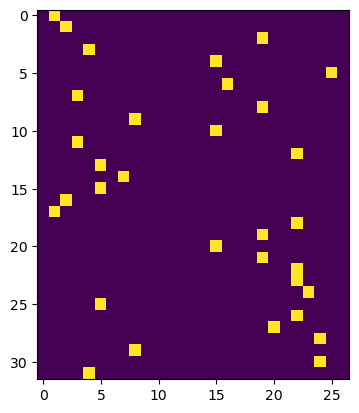

In [29]:
#logits.max(1,keepdim=True)
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [30]:
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [31]:
logits.shape,h.shape,W2.shape,b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [32]:
# h@w1 = (32,27) and b2 = (27)
# so b2 broadcasts into (1,27) and this (1,27) replicates vertically 32 times

In [33]:
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


In [34]:
dW2 = h.T @dlogits 
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


In [35]:
db2 = dlogits.sum(0)
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [36]:
dhpreact = (1.0 - h ** 2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


In [37]:
bngain.shape,bnraw.shape,bnbias.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [38]:
dbngain = (bnraw * dhpreact ).sum(0,keepdim=True)
cmp('bngain', dbngain, bngain)
dbnraw = (bngain * dhpreact)
cmp('bnraw', dbnraw, bnraw)
dbnbias = dhpreact.sum(0,keepdim=True)
cmp('bnbias', dbnbias, bnbias)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0


In [39]:
bnraw.shape,bndiff.shape,bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [40]:
dbndiff = (bnvar_inv * dbnraw)
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


In [41]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


In [42]:
#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar.shape,bndiff2.shape
#a11 a12
#a21 a22
# -- >
#b1 and b2 where:
#b1 = 1/(n-1) * (a11 + a12)
#b2 = 1/(n-1) * (a21 + a22)

(torch.Size([1, 64]), torch.Size([32, 64]))

In [43]:
dbndiff2 = ((1.0/(n-1))*torch.ones_like(bndiff2)) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


In [44]:
#bndiff2 = bndiff**2
dbndiff += 2 * bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


In [45]:
#bndiff = hprebn - bnmeani
bndiff.shape,hprebn.shape,bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [46]:
dbnmeani = (-1.0 * dbndiff).sum(0,keepdim=True) # 
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


In [47]:
dhprebn = dbndiff.clone() * 1.0
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: False | maxdiff: 0.001072533312253654


In [48]:
#bnmeani = 1/n*hprebn.sum(0, keepdim=True)
dhprebn += (1.0/n) * (dbnmeani * torch.ones_like(hprebn))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


In [49]:
#hprebn = embcat @ W1 + b1 
hprebn.shape,embcat.shape,W1.shape,b1.shape,dhprebn.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [50]:
dembcat = (dhprebn @ W1.T)
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [51]:
# emb = C[Xb] # 32,3,10
# embcat = emb.view(emb.shape[0],-1)
embcat.shape,emb.shape,C.shape,Xb.shape
print(Xb[:5]) # which row of C to pluck out

tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [52]:
demb  = dembcat.view(emb.shape)
cmp('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


In [53]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


In [54]:
# cmp('logprobs', dlogprobs, logprobs)
# cmp('probs', dprobs, probs)
# cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# cmp('counts_sum', dcounts_sum, counts_sum)
# cmp('counts', dcounts, counts)
# cmp('norm_logits', dnorm_logits, norm_logits)
# cmp('logit_maxes', dlogit_maxes, logit_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

In [55]:
## Bessels correction in batchNorm


In [58]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3525962829589844 diff: 0.0


In [59]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -=1
dlogits /= n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


In [60]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [61]:
F.softmax(logits, 1)[0]

tensor([0.0693, 0.0868, 0.0194, 0.0505, 0.0193, 0.0811, 0.0223, 0.0372, 0.0171,
        0.0311, 0.0375, 0.0361, 0.0390, 0.0296, 0.0341, 0.0129, 0.0089, 0.0198,
        0.0149, 0.0543, 0.0473, 0.0238, 0.0270, 0.0738, 0.0566, 0.0276, 0.0226],
       grad_fn=<SelectBackward0>)

In [62]:
dlogits[0]

tensor([ 0.0022,  0.0027,  0.0006,  0.0016,  0.0006,  0.0025,  0.0007,  0.0012,
        -0.0307,  0.0010,  0.0012,  0.0011,  0.0012,  0.0009,  0.0011,  0.0004,
         0.0003,  0.0006,  0.0005,  0.0017,  0.0015,  0.0007,  0.0008,  0.0023,
         0.0018,  0.0009,  0.0007], grad_fn=<SelectBackward0>)

In [63]:
dlogits[0] * n

tensor([ 0.0693,  0.0868,  0.0194,  0.0505,  0.0193,  0.0811,  0.0223,  0.0372,
        -0.9829,  0.0311,  0.0375,  0.0361,  0.0390,  0.0296,  0.0341,  0.0129,
         0.0089,  0.0198,  0.0149,  0.0543,  0.0473,  0.0238,  0.0270,  0.0738,
         0.0566,  0.0276,  0.0226], grad_fn=<MulBackward0>)

In [64]:
dlogits[0].sum()

tensor(-5.1223e-09, grad_fn=<SumBackward0>)

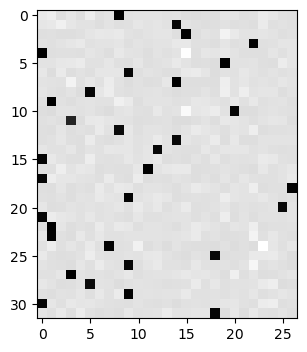

In [65]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# dlogits refers to the probabilties matrix in the forward pass.
# The black refers to the correct indices.
# The force which pulls down probs of incorrect and pull up the probs of correct. The force is directly proportional to probabilites 
# came out in the forward pass

In [66]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [67]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09


In [68]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7729
  10000/ 200000: 2.1874
  20000/ 200000: 2.3926
  30000/ 200000: 2.4312
  40000/ 200000: 1.9744
  50000/ 200000: 2.3155
  60000/ 200000: 2.4311
  70000/ 200000: 2.0831
  80000/ 200000: 2.3176
  90000/ 200000: 2.1535
 100000/ 200000: 2.0058
 110000/ 200000: 2.3770
 120000/ 200000: 1.9886
 130000/ 200000: 2.4161
 140000/ 200000: 2.2826
 150000/ 200000: 2.1692
 160000/ 200000: 1.9258
 170000/ 200000: 1.8513
 180000/ 200000: 2.0236
 190000/ 200000: 1.8597
